In [1]:
import boto3 # AWS SDK for Python
import io # Python's built-in I/O library
import pandas as pd # Python's data manipulation library
from sagemaker import get_execution_role # Amazon SageMaker's specific API library
import numpy as np # Python's numerical library
import matplotlib.pyplot as plt # Python's plotting library
import seaborn as sns # Python's statistical data visualization library
from sklearn.model_selection import train_test_split # Python's machine learning library
from sklearn.preprocessing import StandardScaler # Python's machine learning library
from sklearn.ensemble import RandomForestClassifier # Python's machine learning library
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay # Python's machine learning library

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [2]:
# Define S3 bucket and file details
bucket_name = 'finalproject-group1' # S3 bucket name
file_name = 'healthcare-dataset-stroke-data.csv' # S3 file name
s3_client = boto3.client('s3') # Create an S3 client

In [3]:
# Get the S3 object
obj = s3_client.get_object(Bucket=bucket_name, Key=file_name) # Get the S3 object

In [4]:
# Load data into a pandas DataFrame
data = pd.read_csv(obj['Body'])
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [5]:
# Drop the 'id' column
data.drop('id',axis=1,inplace=True) 

In [6]:
# Check for missing values
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


<Figure size 1000x600 with 0 Axes>

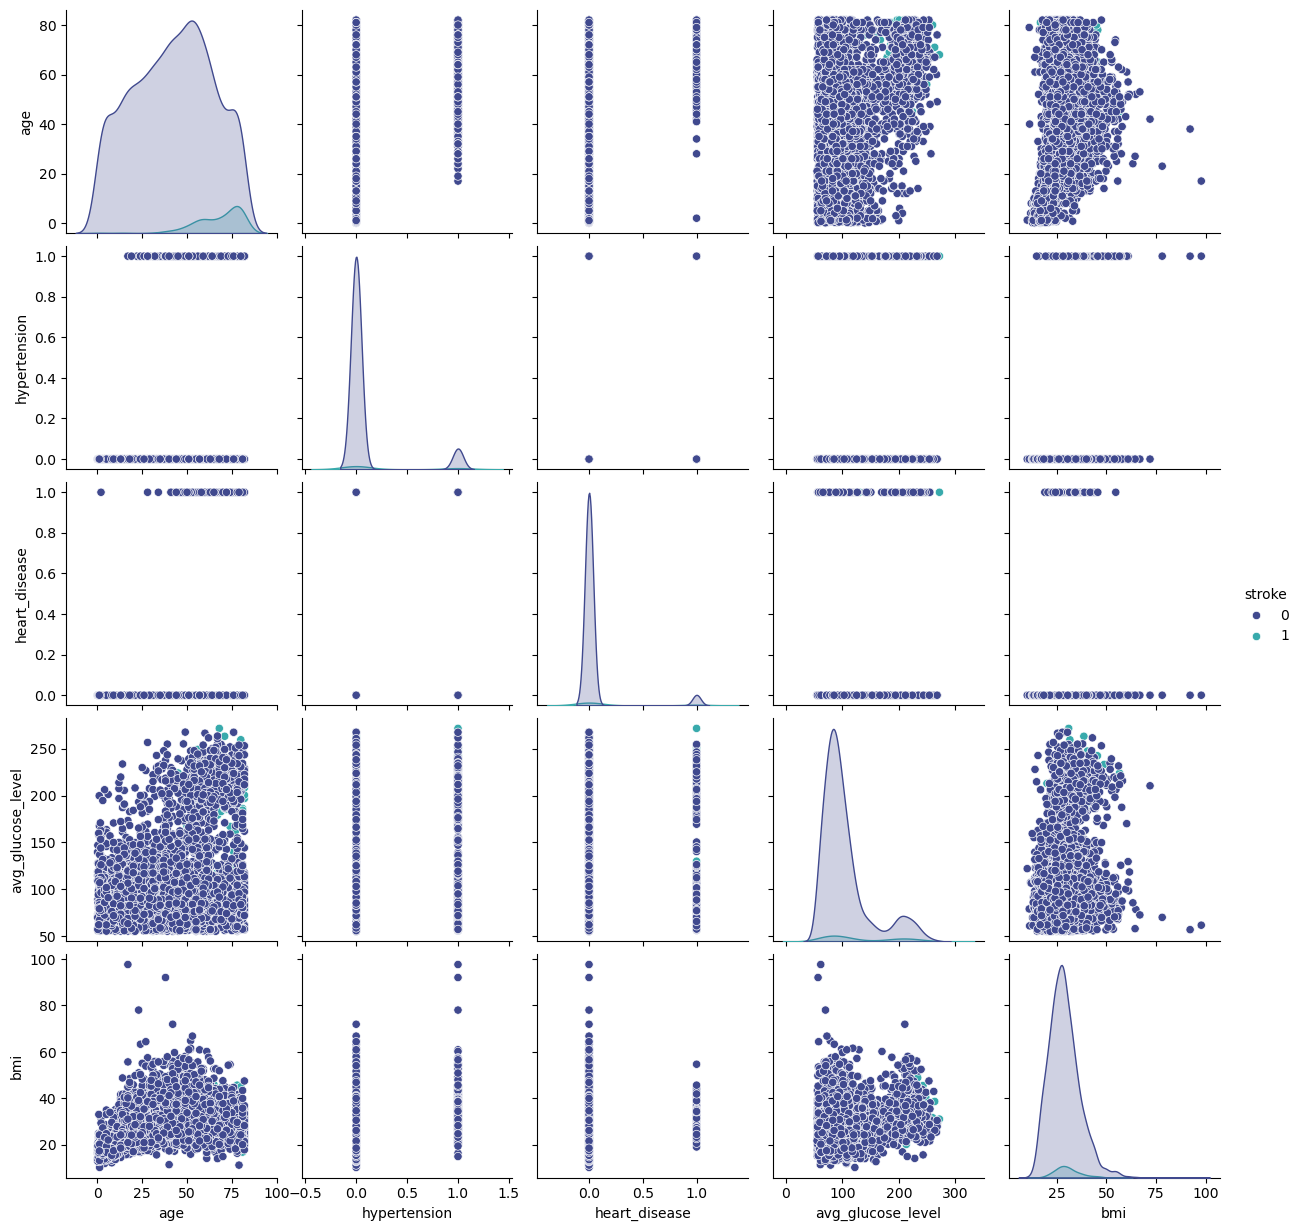

In [7]:
# Fill missing values in 'bmi' column with the mean
plt.figure(figsize=(10,6))
sns.pairplot(data,hue='stroke',palette='mako')

In [8]:
#Checking duplication and nulls
data.duplicated().any()

False

In [9]:
# Check for missing values
data.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [10]:
data.dtypes # Check data types

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [11]:
#Dealing with all the numerical features(nulls/scailing)
numerical = data.select_dtypes(include=['int64','float64']).columns.tolist()
numerical

['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']

<Axes: xlabel='age', ylabel='Count'>

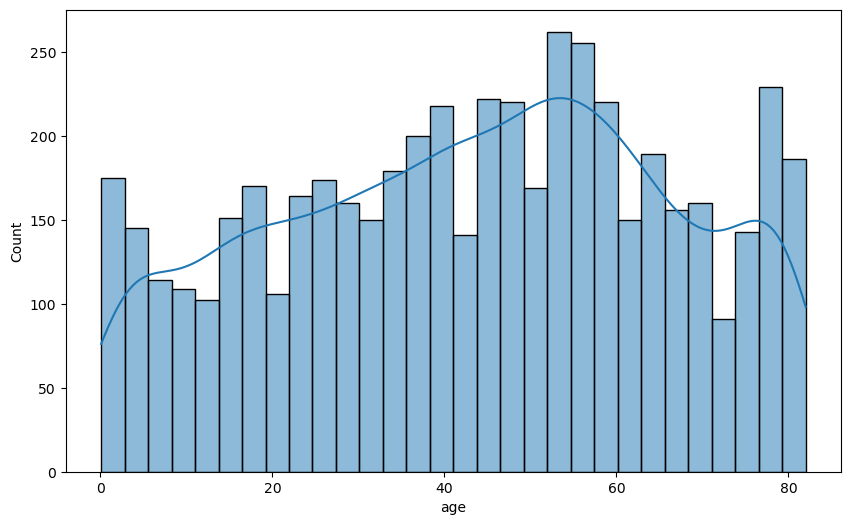

In [12]:
plt.figure(figsize=(10,6)) # Set the figure size
sns.histplot(data.age,kde=True,bins=30) # Create a histogram of the 'age' column

In [13]:
data.age[data.age < 1].value_counts() # Check for ages less than 1

age
0.88    5
0.32    5
0.24    5
0.72    5
0.56    5
0.64    4
0.80    4
0.48    3
0.16    3
0.40    2
0.08    2
Name: count, dtype: int64

In [14]:
#Is that a mistake? Let's check the age distribution
data[data.age < 1]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
363,Female,0.64,0,0,No,children,Urban,83.82,24.9,Unknown,0
376,Female,0.88,0,0,No,children,Rural,88.11,15.5,Unknown,0
564,Female,0.32,0,0,No,children,Rural,73.71,16.2,Unknown,0
982,Male,0.88,0,0,No,children,Rural,157.57,19.2,Unknown,0
996,Male,0.24,0,0,No,children,Rural,118.87,16.3,Unknown,0
1093,Female,0.32,0,0,No,children,Rural,55.86,16.0,Unknown,0
1206,Female,0.72,0,0,No,children,Urban,66.36,23.0,Unknown,0
1317,Male,0.80,0,0,No,children,Rural,98.67,17.5,Unknown,0
1600,Male,0.40,0,0,No,children,Urban,109.56,14.3,Unknown,0
1614,Female,0.08,0,0,No,children,Urban,139.67,14.1,Unknown,0


In [15]:
data.work_type[data.age < 1] == 'children' # Check if the 'work_type' is 'children'

363     True
376     True
564     True
982     True
996     True
1093    True
1206    True
1317    True
1600    True
1614    True
1808    True
1975    True
1999    True
2008    True
2012    True
2030    True
2358    True
2481    True
2490    True
2579    True
2630    True
2801    True
2875    True
2898    True
3251    True
3295    True
3392    True
3440    True
3618    True
3626    True
3859    True
3894    True
3968    True
4007    True
4021    True
4053    True
4293    True
4409    True
4581    True
4645    True
4910    True
4929    True
5089    True
Name: work_type, dtype: bool

In [16]:
data.hypertension.value_counts() # Check the value counts of the 'hypertension' column

hypertension
0    4612
1     498
Name: count, dtype: int64

([<matplotlib.patches.Wedge at 0x7fcd5d7c4580>,
 [Text(-1.3348942113978373, 0.42196853481811436, 'No Hypertension'),
  Text(1.1441950298751005, -0.3616873423402018, 'Hypertension')],
 [Text(-0.8581462787557526, 0.2712654866687878, '90.3%'),
  Text(0.6674471007604752, -0.21098428303178438, '9.7%')])

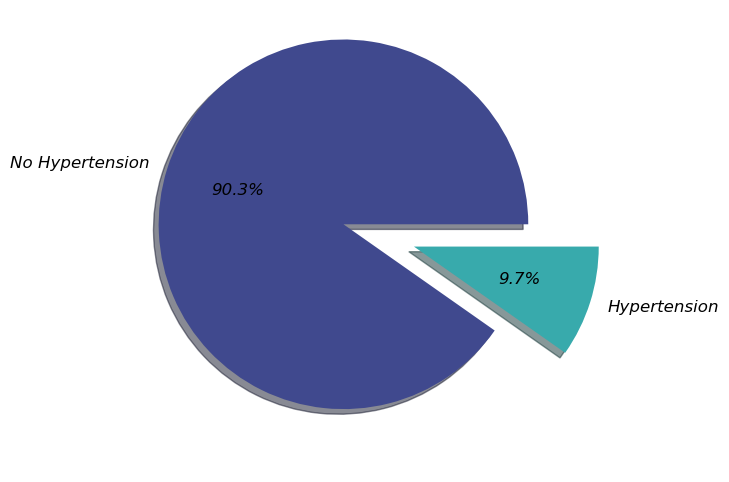

In [17]:
# Create a pie chart of the 'hypertension' column
plt.figure(figsize=(10,6)) # Set the figure size
plt.pie(data.hypertension.value_counts(),labels=['No Hypertension','Hypertension'],autopct='%1.1f%%',
        colors=sns.color_palette('mako',2),explode=(0.3,0.1),shadow=True,textprops={'fontsize':12,'style':'italic'}) 

In [18]:
# Check the value counts of the 'heart_disease' column
data.heart_disease.value_counts() 

heart_disease
0    4834
1     276
Name: count, dtype: int64

([<matplotlib.patches.Wedge at 0x7fcd5d7fba30>,
 [Text(-1.3798936980729009, 0.23641781239723444, 'No Heart disease'),
  Text(1.182766015061574, -0.2026439084092213, 'Heart disease')],
 [Text(-0.8870745201897219, 0.1519828793982221, '94.6%'),
  Text(0.6899468421192514, -0.11820894657204575, '5.4%')])

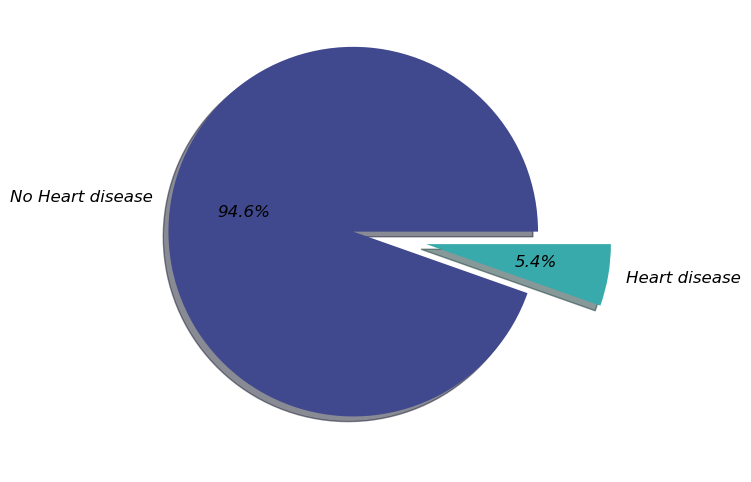

In [19]:
# Create a pie chart of the 'heart_disease' column
plt.figure(figsize=(10,6))
plt.pie(data.heart_disease.value_counts(),labels=['No Heart disease','Heart disease'],autopct='%1.1f%%',
        colors=sns.color_palette('mako',2),explode=(0.3,0.1),shadow=True,textprops={'fontsize':12,'style':'italic'})

<Axes: xlabel='avg_glucose_level', ylabel='Count'>

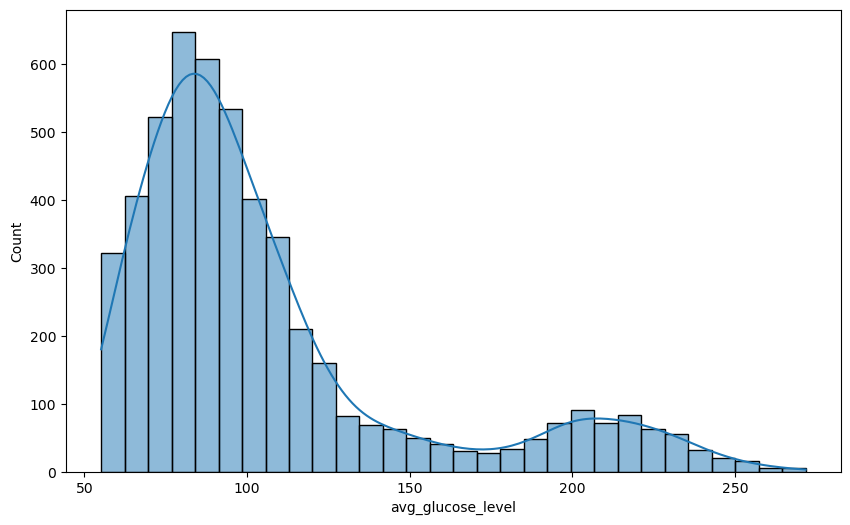

In [20]:
# Check the value counts of the 'ever_married' column
plt.figure(figsize=(10,6))
sns.histplot(data.avg_glucose_level,kde=True,bins=30)

In [21]:
# Check the value counts of the 'ever_married' column
data.avg_glucose_level.describe()

count    5110.000000
mean      106.147677
std        45.283560
min        55.120000
25%        77.245000
50%        91.885000
75%       114.090000
max       271.740000
Name: avg_glucose_level, dtype: float64

<Axes: xlabel='bmi', ylabel='Count'>

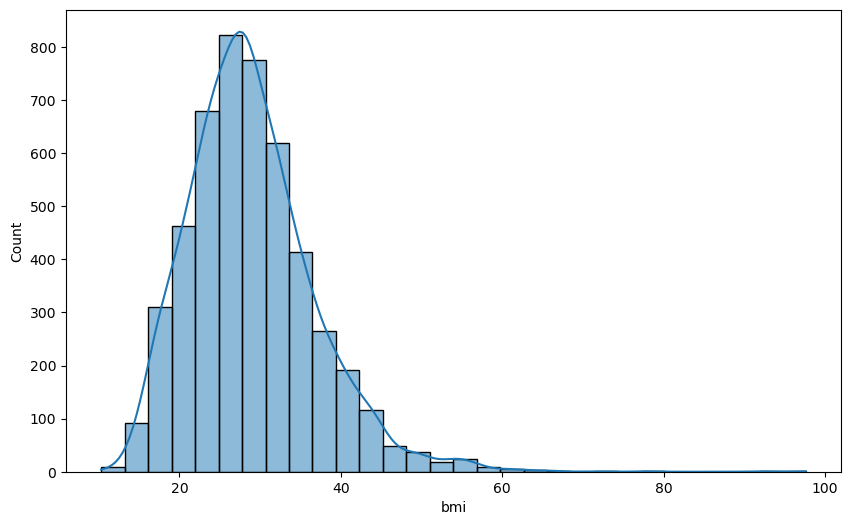

In [22]:
# Check the value counts of the 'ever_married' column
plt.figure(figsize=(10,6))
sns.histplot(data.bmi,kde=True,bins=30)

In [23]:
# Check the value counts of the 'ever_married' column
data.bmi.describe()

count    4909.000000
mean       28.893237
std         7.854067
min        10.300000
25%        23.500000
50%        28.100000
75%        33.100000
max        97.600000
Name: bmi, dtype: float64

In [24]:
#Dealing with the nulls
data.fillna({'bmi': data['bmi'].mean()}, inplace=True)

<Axes: ylabel='age'>

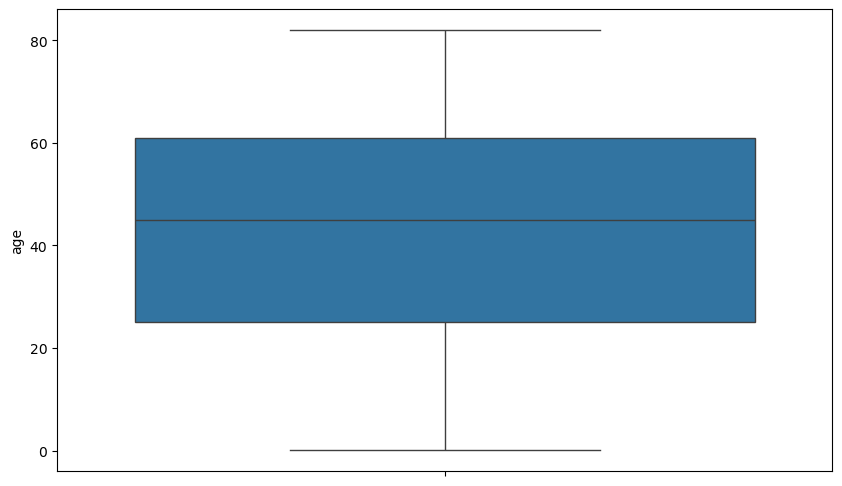

In [25]:
#Checking for outliers
plt.figure(figsize=(10,6))
sns.boxplot(data.age)

<Axes: ylabel='avg_glucose_level'>

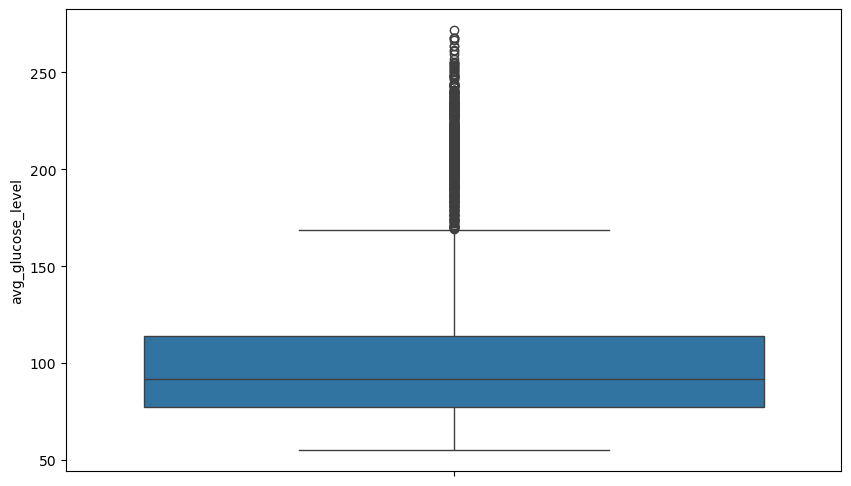

In [26]:
#Checking for outliers
plt.figure(figsize=(10,6))
sns.boxplot(data.avg_glucose_level)

<Axes: ylabel='bmi'>

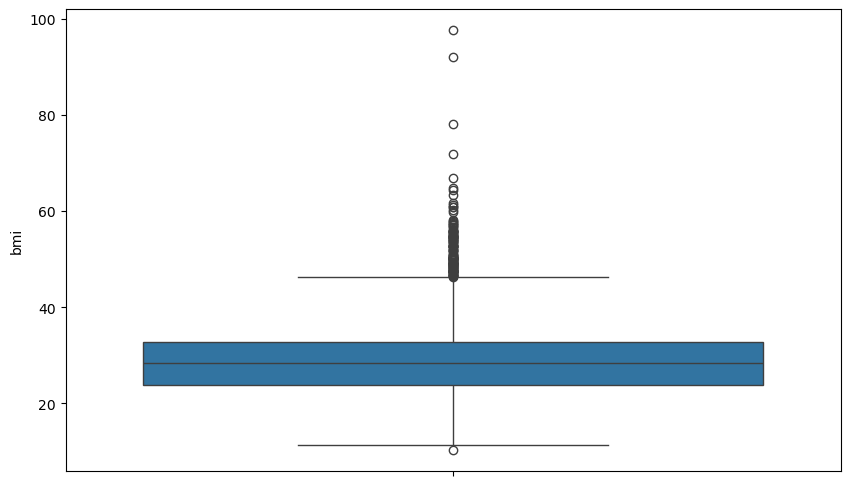

In [27]:
#Checking for outliers
plt.figure(figsize=(10,6))
sns.boxplot(data.bmi)

In [28]:
#Scaling numerial features
data[numerical[:-1]] = StandardScaler().fit_transform(data[numerical[:-1]])

In [29]:
data.describe() # Check the summary statistics

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5.110000e+03,5.110000e+03,5.110000e+03,5.110000e+03,5.110000e+03,5110.000000
mean,5.005781e-17,-4.727682e-17,5.561978e-18,1.001156e-16,2.224791e-17,0.048728
std,1.000098e+00,1.000098e+00,1.000098e+00,1.000098e+00,1.000098e+00,0.215320
min,-1.908261e+00,-3.286019e-01,-2.389468e-01,-1.126958e+00,-2.415564e+00,0.000000
25%,-8.061152e-01,-3.286019e-01,-2.389468e-01,-6.383223e-01,-6.616944e-01,0.000000
50%,7.843218e-02,-3.286019e-01,-2.389468e-01,-3.149945e-01,-6.407951e-02,0.000000
75%,7.860701e-01,-3.286019e-01,-2.389468e-01,1.754080e-01,5.075521e-01,0.000000
max,1.714845e+00,3.043196e+00,4.185032e+00,3.657145e+00,8.926127e+00,1.000000


In [30]:
#Dealing with all the categorical features(nulls (if exists)/encoding)
categories = data.select_dtypes(include=['object']).columns.tolist()
categories

['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

In [31]:
data.gender.value_counts() # Check the gender counts

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64

In [32]:
#Dropping "other" as it should be male or female
data.drop(data[data.gender == 'Other'].index,inplace=True)
data.reset_index(drop=True,inplace=True)

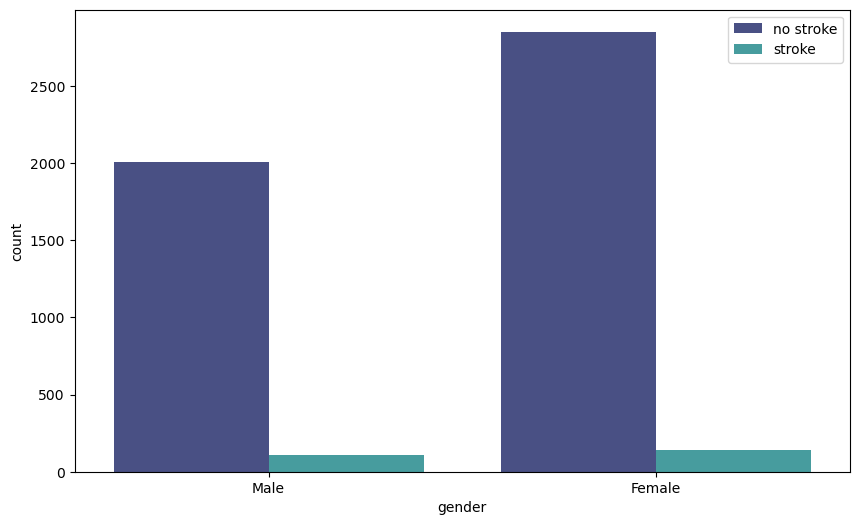

In [33]:
# Check the percentage of stroke cases in gender
plt.figure(figsize=(10,6))
sns.countplot(x="gender", data=data, palette='mako',hue='stroke')
plt.legend(['no stroke','stroke'])

In [34]:
#Mapping the gender
data.gender = data.gender.map({'Male':0,'Female':1})

In [35]:
data.ever_married.value_counts() # Check the value counts of the 'ever_married' column

ever_married
Yes    3353
No     1756
Name: count, dtype: int64

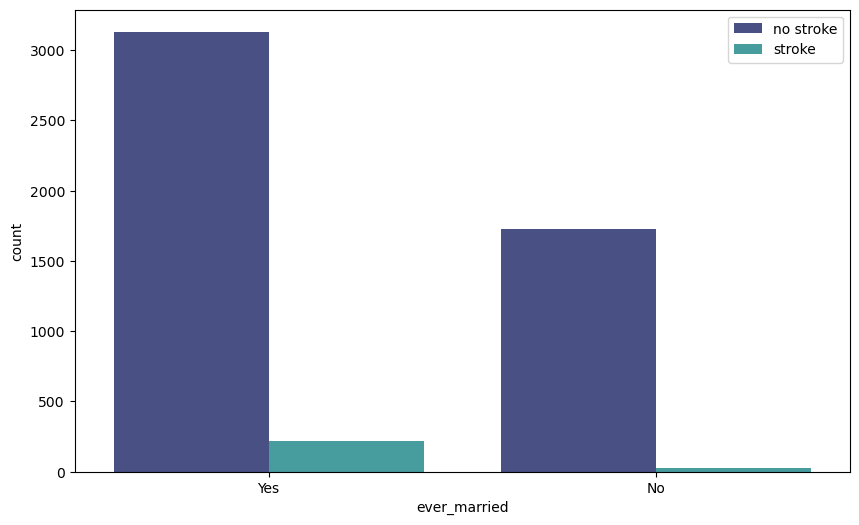

In [36]:
plt.figure(figsize=(10,6)) # Set the figure size
sns.countplot(x="ever_married", data=data, palette='mako',hue='stroke') # Create a count plot of the 'ever_married' column
plt.legend(['no stroke','stroke']) # Add a legend

In [37]:
#Mapping the ever_married
data.ever_married = data.ever_married.map({'No':0,'Yes':1})

In [38]:
# Check the value counts of the 'work_type' column
data.work_type.value_counts()

work_type
Private          2924
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: count, dtype: int64

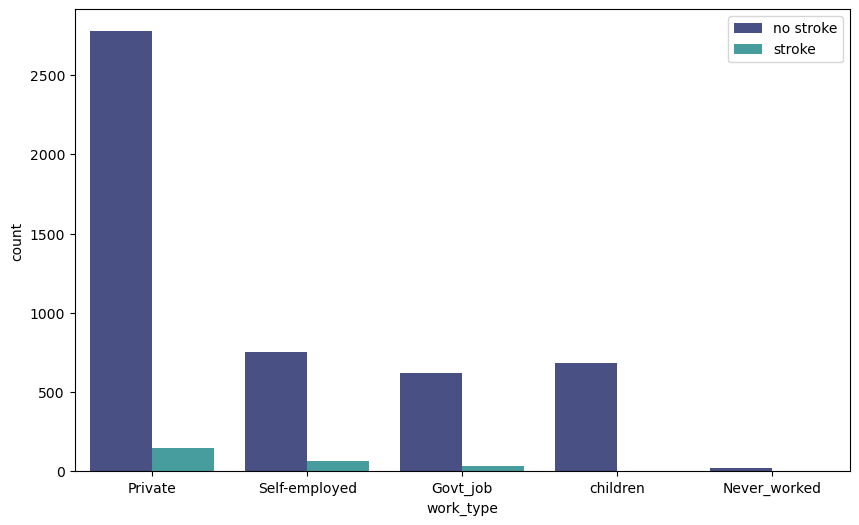

In [39]:
# Check the percentage of stroke cases in work_type
plt.figure(figsize=(10,6))
sns.countplot(x="work_type", data=data, palette='mako',hue='stroke')
plt.legend(['no stroke','stroke'])

In [40]:
#Mapping the work_type
data.work_type = data.work_type.map({'Private':0,'Self-employed':1,'children':2,'Govt_job':3,'Never_worked':4})

In [41]:
data.Residence_type.value_counts() # Check the value counts of the 'Residence_type' column

Residence_type
Urban    2596
Rural    2513
Name: count, dtype: int64

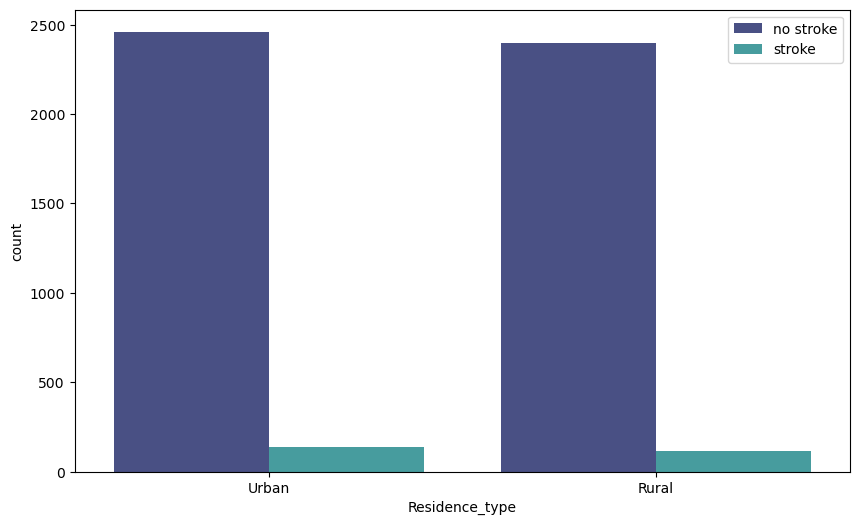

In [42]:
plt.figure(figsize=(10,6)) # Set the figure size
sns.countplot(x="Residence_type", data=data, palette='mako',hue='stroke') # Create a count plot of the 'Residence_type' column
plt.legend(['no stroke','stroke']) # Add a legend

In [43]:
#Mapping the residence_type
data.Residence_type = data.Residence_type.map({'Urban':0,'Rural':1})

In [44]:
data.smoking_status.value_counts() # Check the value counts of the 'smoking_status' column

smoking_status
never smoked       1892
Unknown            1544
formerly smoked     884
smokes              789
Name: count, dtype: int64

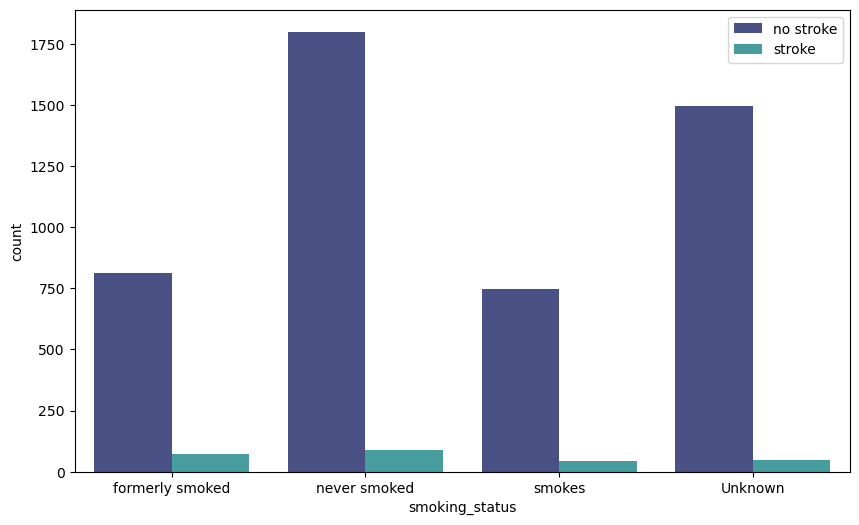

In [45]:
plt.figure(figsize=(10,6)) # Set the figure size
sns.countplot(x="smoking_status", data=data, palette='mako',hue='stroke') # Create a count plot of the 'smoking_status' column
plt.legend(['no stroke','stroke']) # Add a legend

In [46]:
#Mapping the smoking_status
data.smoking_status = data.smoking_status.map({'never smoked':0,'formerly smoked':1,'smokes':2,'Unknown':3})

In [47]:
# Check the first few rows
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,1.051434,-0.328602,4.185032,1,0,0,2.706375,1.001234e+00,1,1
1,1,0.786070,-0.328602,-0.238947,1,1,1,2.121559,4.615554e-16,0,1
2,0,1.626390,-0.328602,4.185032,1,0,1,-0.005028,4.685773e-01,0,1
3,1,0.255342,-0.328602,-0.238947,1,0,0,1.437358,7.154182e-01,2,1
4,1,1.582163,3.043196,-0.238947,1,1,1,1.501184,-6.357112e-01,0,1


<Axes: >

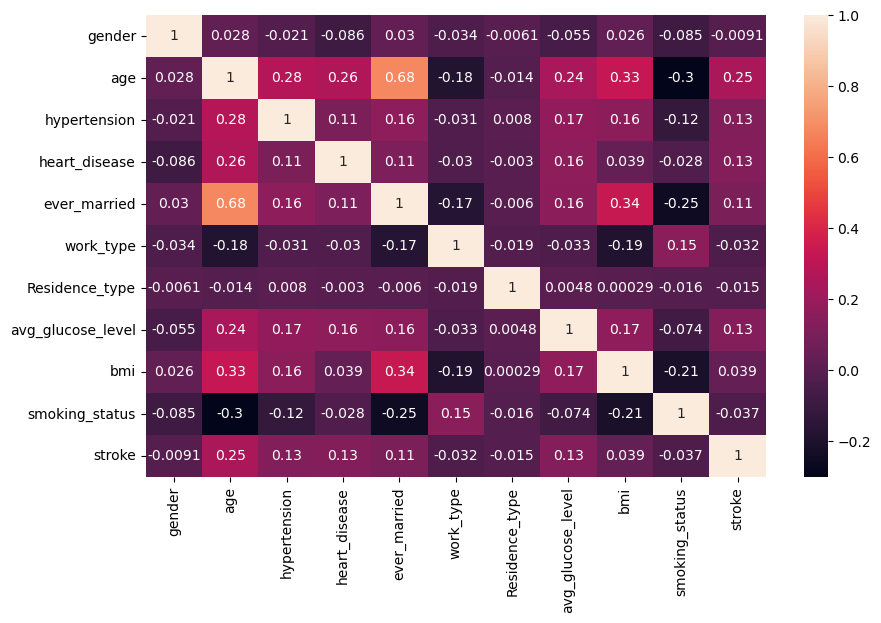

In [48]:
#Checking for correlation
plt.figure(figsize=(10,6))
sns.heatmap(data.corr(),annot=True)

In [49]:
#Splitting the data
X = data.drop('stroke',axis=1)
y = data.stroke
X.shape,y.shape

((5109, 10), (5109,))

In [50]:
y.value_counts() # Check the value counts of the target variable

stroke
0    4860
1     249
Name: count, dtype: int64

([<matplotlib.patches.Wedge at 0x7fcd56972fb0>,
 [Text(-1.3836214247114578, 0.21352225429550808, 'No Stroke'),
  Text(1.1859612190393143, -0.18301908899014838, 'Stroke')],
 [Text(-0.8894709158859372, 0.13726430633282663, '95.1%'),
  Text(0.6918107111062667, -0.10676113524425322, '4.9%')])

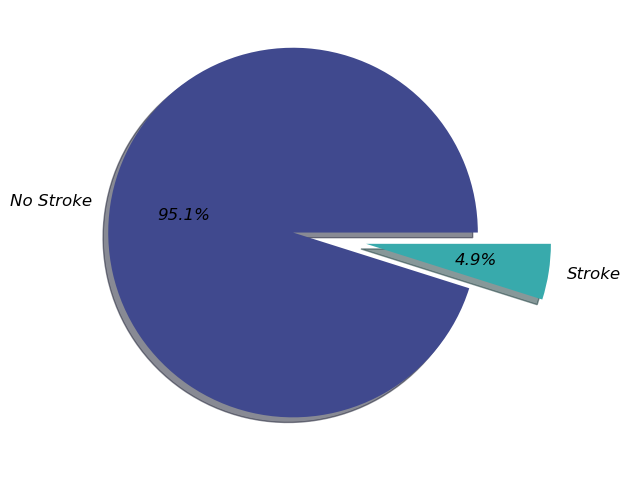

In [51]:
# Create a pie chart for Stroke vs. No Stroke
plt.figure(figsize=(10,6)) # Set the figure size
plt.pie(data.stroke.value_counts(),labels=['No Stroke','Stroke'],autopct='%1.1f%%',
        colors=sns.color_palette('mako',2),explode=(0.3,0.1),shadow=True,textprops={'fontsize':12,'style':'italic'}) 

In [52]:
# Move 'stroke' column to the first position
data = data[['stroke'] + [col for col in data.columns if col != 'stroke']]

# Check the reordering
data.head()

,stroke,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,1,0,1.051434,-0.328602,4.185032,1,0,0,2.706375,1.001234e+00,1
1,1,1,0.786070,-0.328602,-0.238947,1,1,1,2.121559,4.615554e-16,0
2,1,0,1.626390,-0.328602,4.185032,1,0,1,-0.005028,4.685773e-01,0
3,1,1,0.255342,-0.328602,-0.238947,1,0,0,1.437358,7.154182e-01,2
4,1,1,1.582163,3.043196,-0.238947,1,1,1,1.501184,-6.357112e-01,0


In [58]:
#Splitting the data into training and validation sets
train_data, validation_data = train_test_split(data, test_size=0.2, random_state=42)

In [53]:
#Converting the DataFrame to CSV and upload it to S3
#buffer = io.StringIO()
#data.to_csv(buffer, index=False)
#buffer.seek(0)

In [59]:
# Initialize a boto3 client
s3_client = boto3.client('s3')
bucket = 'finalproject-group1'
prefix = 'PreProcessed Data'

In [55]:
#Saving it to S3
#s3_resource = boto3.resource('s3')
#s3_resource.Object(bucket, file_path).put(Body=buffer.getvalue())

In [61]:
#Convert training data to CSV and upload it to S3
train_buffer = io.StringIO()
train_data.to_csv(train_buffer, header=False, index=False)
train_buffer.seek(0)
s3_client.put_object(Bucket=bucket, Body=train_buffer.getvalue(), Key=f"{prefix}/train/train-processed-healthcare-dataset-stroke-data.csv")

#Convert validation data to CSV and upload it to S3
validation_buffer = io.StringIO()
validation_data.to_csv(validation_buffer, header=False, index=False)
validation_buffer.seek(0)
s3_client.put_object(Bucket=bucket, Body=validation_buffer.getvalue(), Key=f"{prefix}/validation/validation-processed-healthcare-dataset-stroke-data.csv")

{'ResponseMetadata': {'RequestId': 'FHKYTGM5VBSH839Z',
  'HostId': '9L/9fW5Riop7LHrdAW0COCunzq1FzjgE+ZN/OgsPrGQrroFkOk7eUoPUnrGXAKAacfeTpfNlmx0=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '9L/9fW5Riop7LHrdAW0COCunzq1FzjgE+ZN/OgsPrGQrroFkOk7eUoPUnrGXAKAacfeTpfNlmx0=',
   'x-amz-request-id': 'FHKYTGM5VBSH839Z',
   'date': 'Mon, 01 Apr 2024 10:54:17 GMT',
   'x-amz-version-id': 'QlyuSp1h58plypbTpPLffM_3t7APhH8E',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"6de066043c54ada7142a438dd7cfbc9b"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"6de066043c54ada7142a438dd7cfbc9b"',
 'ServerSideEncryption': 'AES256',
 'VersionId': 'QlyuSp1h58plypbTpPLffM_3t7APhH8E'}